In [22]:
import pathlib as pl
from configparser import ConfigParser
import re

import pandas as pd
from IPython.display import Image

import joblib as jl
import numpy as np
import scipy.stats as sst
from scikit_posthocs import posthoc_dunn
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from nems import db as nd

from src.root_path import config_path, root_path
from src.visualization.palette import *

In [ ]:
config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

# Loads information about sounds used per experiment

In [160]:
def add_named_sounds(in_df):
    """
    Adds names for the two contexts and probe for every instance in the table

    Args:
        in_df: a pandas DF containing 'cellid', 'context_pair' and 'probe' columns

    Returns:
        out_df: a pandas DF, copy of in_df, with the extra columns 'named_ctx_0', 'named_ctx_1', 'named_probe'
    """

    # create a map between the numbers of the sound indices and the sounds used
    sound_folder = pl.Path('/auto/users/mateo/code/baphy/Config/lbhb/SoundObjects/@NaturalPairs/NatPairSounds')
    sound_files = np.asarray([sfile.stem for sfile in sound_folder.iterdir()])

    num2name = dict()
    for nn, filename in enumerate(sound_files):
        glob_idx, name = re.findall(r'\A(\d{2})_cat\d{2,3}_rec\d{1}_(.*)_excerpt\d{1}_\d{1,2}', filename)[0]
        # print(int(glob_idx), name)
        num2name[int(glob_idx)] = name

    # get All permutations sites with the numbered sounds used for stimulation
    sound_DF = nd.pd_query("SELECT sCellFile.cellid as site, gData.svalue as SoundStructure,"
                     "g2.svalue as SoundIdexes FROM sCellFile "
                     "INNER JOIN gData ON gData.rawid=sCellFile.rawid AND gData.name='Ref_SequenceStructure' "
                     "INNER JOIN gData g2 ON g2.rawid=sCellFile.rawid AND g2.name='Ref_SoundIndexes' "
                     "INNER JOIN gData g3 ON g3.rawid=sCellFile.rawid AND g3.name='ReferenceClass' "
                     "WHERE gData.svalue='AllPermutations' AND g3.svalue='NaturalPairs' AND sCellFile.RunClassid=121"
                     )

    # clean up DF
    sound_DF['site'] = sound_DF.site.apply(nd.get_siteid)
    sound_DF.drop_duplicates(inplace=True)

    # formats sound indexes into arrays
    sound_DF['SoundIdexes'] = sound_DF['SoundIdexes'].apply(lambda x: [int(s) for s in x[1:-1].split(' ')])

    # makes an extra column with the dict mappers
    sound_DF['mapper'] = sound_DF['SoundIdexes'].apply(lambda x: {jj+1:num2name[idx] for jj, idx in enumerate(x)})

    # to reduce redundant computation, finds the mapping between numbers and names for site*contex_pair*probe
    named_sounds_df = in_df.loc[:, ['site', 'context_pair', 'probe']].drop_duplicates().copy()
    named_sounds_df['named_probe'] = named_sounds_df['probe'].astype(int)

    # splits context pair into two numerical context colums
    named_sounds_df[['named_ctx_0', 'named_ctx_1']] = pd.DataFrame(
        named_sounds_df.context_pair.str.split('_').tolist(), index=named_sounds_df.index).astype(int)

    # replace numbers by sound name per site, as the same number correspond to different sound on different site
    for site in named_sounds_df.site.unique():
        idx2name = sound_DF.query(f"site == '{site}'").mapper.values[0]
        idx2name[0] = 'silence'
        named_sounds_df.update(
            named_sounds_df.loc[named_sounds_df.site == site, ['named_ctx_0', 'named_ctx_1', 'named_probe']].replace(idx2name)
        )

    # categorical columns for low memory use and fast operations
    for col in ['named_probe', 'named_ctx_0', 'named_ctx_1']:
        named_sounds_df[col] = named_sounds_df[col].astype('category')

    # merge names  into full original DF
    out_df = pd.merge(in_df, named_sounds_df, on=['site', 'context_pair', 'probe'], validate='m:1')

    return out_df


def kruskal_with_posthoc(df, group_col, val_col):
    # pools data in a list of vectors to run kruskal
    to_stat = list()
    for kk in df[group_col].unique():
        to_stat.append(df.loc[df[group_col] == kk, val_col].values)
    kruskal = sst.kruskal(*to_stat)
    print(kruskal)
    # uses the og dataframe to run the pairwise posthoc test
    dunn = posthoc_dunn(df, val_col=val_col, group_col=group_col, p_adjust='bonferroni')
    print(f'Dunn post hoc results\n{dunn}')

    return kruskal, dunn

# Loads context effecs data and preformats

In [162]:
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / '220520_minimal_DF'
# Cluster Mass significant contextual effects
# summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'

metrics = ['integral', 'last_bin']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and source == 'real' and "
                                    f"diff_metric == 'delta_FR' and "
                                    f"value > 0")

DF.loc[DF.metric == 'integral', 'value'] = DF.loc[DF.metric == 'integral', 'value'] /1000  # ms to s for better display
DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)

print(DF.shape)
print(DF.head())

(91812, 8)
              id context_pair probe     value    metric diff_metric     site  \
0  TNC013a-019-3        00_01     1  0.181284  integral    delta_FR  TNC013a   
1  TNC013a-036-3        00_01     1  0.337167  integral    delta_FR  TNC013a   
2  TNC013a-042-9        00_01     1  0.192177  integral    delta_FR  TNC013a   
3  TNC013a-046-1        00_01     1  0.134207  integral    delta_FR  TNC013a   
4  TNC013a-036-3        00_02     1  0.346280  integral    delta_FR  TNC013a   

  region  
0     A1  
1     A1  
2     A1  
3     A1  
4     A1  


In [163]:
merged = add_named_sounds(DF)

merged['voc_ctx'] = 'sound'
merged['voc_prb'] = 'sound'

vocalizations = ['ferret_fights_Athena-Violet001', 'ferret_fights_Jasmine-Violet001']
merged.loc[(merged.named_ctx_0.isin(vocalizations)) |
           (merged.named_ctx_1.isin(vocalizations)),
           'voc_ctx'] = 'vocalization'
merged.loc[merged.named_probe.isin(vocalizations), 'voc_prb'] = 'vocalization'

,id,context_pair,probe,value,metric,diff_metric,site,region,named_probe,named_ctx_0,named_ctx_1
0,TNC013a-019-3,00_01,1,0.181284,integral,delta_FR,TNC013a,A1,cash_register,silence,cash_register
1,TNC013a-036-3,00_01,1,0.337167,integral,delta_FR,TNC013a,A1,cash_register,silence,cash_register
2,TNC013a-042-9,00_01,1,0.192177,integral,delta_FR,TNC013a,A1,cash_register,silence,cash_register
3,TNC013a-046-1,00_01,1,0.134207,integral,delta_FR,TNC013a,A1,cash_register,silence,cash_register
4,TNC013a-019-3,00_01,1,350.000000,last_bin,delta_FR,TNC013a,A1,cash_register,silence,cash_register
...,...,...,...,...,...,...,...,...,...,...,...
91807,ARM017a-22-1,02_03,4,250.000000,last_bin,delta_FR,ARM017a,PEG,factory_sounds,latin-pop_enrique-iglesias_i-will-survive,pop_kelly-clarkson_einstein
91808,ARM017a-22-1,02_04,4,0.108369,integral,delta_FR,ARM017a,PEG,factory_sounds,latin-pop_enrique-iglesias_i-will-survive,factory_sounds
91809,ARM017a-63-1,02_04,4,0.076218,integral,delta_FR,ARM017a,PEG,factory_sounds,latin-pop_enrique-iglesias_i-will-survive,factory_sounds
91810,ARM017a-22-1,02_04,4,100.000000,last_bin,delta_FR,ARM017a,PEG,factory_sounds,latin-pop_enrique-iglesias_i-will-survive,factory_sounds


# plot the effect following old standards


######### integral voc_ctx #########

KruskalResult(statistic=15.30699082887494, pvalue=9.137772027668053e-05)
Dunn post hoc results
                 sound  vocalization
sound         1.000000      0.000091
vocalization  0.000091      1.000000

data summary stats
                  stat       err  count
voc_ctx                               
sound         0.23583  0.000993  37448
vocalization  0.23920  0.001945   8458

######### integral voc_prb #########

KruskalResult(statistic=26.001541997910866, pvalue=3.411447707770549e-07)
Dunn post hoc results
                     sound  vocalization
sound         1.000000e+00  3.411448e-07
vocalization  3.411448e-07  1.000000e+00

data summary stats
                   stat       err  count
voc_prb                                
sound         0.237010  0.000926  41502
vocalization  0.231186  0.003010   4404

######### last_bin voc_ctx #########

KruskalResult(statistic=23.01186952244701, pvalue=1.610042750779902e-06)
Dunn post hoc results
     

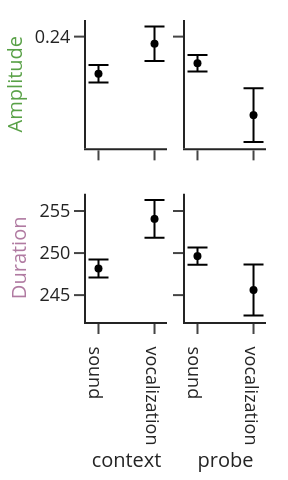

In [177]:
def plot_metric_quant_bars(df, metric, category):
    print(f'\n######### {metric} {category} #########\n')
    df = df.query(f"metric == '{metric}'")


    _ = kruskal_with_posthoc(df, group_col=category, val_col='value')
    df = df.groupby(by=category, observed=True).agg(stat=('value', np.mean),
                                                    err=('value', sst.sem),
                                                    count=('value', 'count'))

    print('\ndata summary stats\n', df)

    x = ['sound', 'vocalization']
    y = [df.at[cat, 'stat'] for cat in x]
    yerr = [df.at[cat, 'err'] for cat in x]
    return [
        go.Scatter(x=x, y=y, mode='markers',
                   marker=dict(color='black',
                               size=4),
                   error_y=dict(array=yerr,
                                color='black',
                                thickness=1,
                                width=5),
                   showlegend=False)
    ]


fig = make_subplots(2, 2, column_width=[0.5, 0.5], shared_xaxes='columns', shared_yaxes='rows')
for mm, met in enumerate(['integral', 'last_bin']):
    for cc, cat in enumerate(['voc_ctx', 'voc_prb']):
        pan = plot_metric_quant_bars(merged, met, cat)
        fig.add_traces(pan, cols=[cc + 1] * len(pan), rows=[mm + 1] * len(pan))

w, h = 1.5, 2.5
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10),

                  yaxis=dict(title=dict(text="Amplitude", font_color=AMPCOLOR, ),
                             tickmode='linear', tick0=0.16, dtick=0.04
                             ),
                  yaxis2=dict(
                             tickmode='linear', tick0=0.16, dtick=0.04
                             ),

                  xaxis3=dict(title=dict(text='context')),
                  yaxis3=dict(title=dict(text='Duration', font_color=DURCOLOR),
                              ),

                  xaxis4=dict(title=dict(text='probe')),
                  showlegend=False,
                  )

fig.update_xaxes(title_font_size=10, title_standoff=0, tickfont_size=9)
fig.update_yaxes(title_font_size=10, title_standoff=0, tickfont_size=9)

filename = folder / 'fig7_vocalization_effects'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", scale=2)
Image(img_bytes)